In [2]:
import pandas as pd
import geopandas as gp
import numpy as np
import cenpy
import matplotlib.pyplot as plt
from tkinter import *

In [5]:
## paper data
f = 'erl_14_8_084011_sd_3.csv'
db = pd.read_csv(f)

sctg_dict = {'Live Animals and Fish':'sctg_1', 
             'Cereal Grains (including seed)':'sctg_2',
             'Agricultural Products except Animal Feed, Cereal Grains, and Forage Products':'sctg_3',
             'Animal Feed, Eggs, Honey, and Other Products of Animal Origin':'sctg_4',
             'Meat, Poultry, Fish, Seafood, and Their Preparations':'sctg_5',
             'Milled Grain Products and Preparations, and Bakery Products':'sctg_6',
             'Other Prepared Foodstuffs, Fats and Oils':'sctg_7',
             'Total':'total'}
ckeys = list(sctg_dict.keys())

## changing fips codes into five digits
a = []
for i in db['ori']:
    i = str(i)
    i = i.zfill(5)
    a.append(i)
db['ori'] = a

b = []
for i in db['des']:
    i = str(i)
    i = i.zfill(5)
    b.append(i)
db['des'] = b

## census data 

fips = cenpy.explorer.fips_table("county")

## creating a fips code column
fips[5] = ""
fips[6] = ""

a = [] 
for i in fips[1]:
    i = str(i)
    i = i.zfill(2)
    a.append(i)
fips[5] = a

b = []
for i in fips[2]:
    i = str(i)
    i = i.zfill(3)
    b.append(i)
fips[6] = b

fips[7] = fips[5] + fips[6]

fips.columns = ['state','col2','col3','name','col5','FIPS_state','FIPS_county','FIPS']
fips.drop(['col2','col3','col5'],axis=1, inplace = True)
fips = fips[fips.FIPS_state < '57']

fips['fullname'] = fips['name'] + ", " + fips['state']
fipsdict = dict(zip(fips['fullname'],fips['FIPS']))
dkeys = list(fipsdict.keys())

gdf = gp.read_file("counties.shp")
print(ckeys)

['Live Animals and Fish', 'Cereal Grains (including seed)', 'Agricultural Products except Animal Feed, Cereal Grains, and Forage Products', 'Animal Feed, Eggs, Honey, and Other Products of Animal Origin', 'Meat, Poultry, Fish, Seafood, and Their Preparations', 'Milled Grain Products and Preparations, and Bakery Products', 'Other Prepared Foodstuffs, Fats and Oils', 'Total']


In [24]:
# defining a function to convert user inputs into geojson file
def select_county(geo_input, dir_input, com_input):
    ## defining "geo_val" as the fips equivalent of a user inputted county
    geo_val = fipsdict.get(geo_input)
    ## defining "com_val" as the sctg column equivalent of a user inputted sctg category
    com_val = sctg_dict.get(com_input)
    ## limit to origin db val (single county selection)
    limval = db[db.ori == geo_val]
    if dir_input == 'Origin':
        ## grouping by destination (destination counties for one origin county)
        limval = limval.groupby(['des'])[com_val].sum()
    else:
        ## grouping by origin (origin counties for one destination county)
        limval = limval.groupby(['ori'])[com_val].sum()  
    ## converting back to dataframe
    dfval = pd.DataFrame({'FIPS':limval.index, com_val:limval.values})
    ## join total value to gdf by the FIPS column
    gdf_new = gdf.merge(dfval, how = 'left', on='FIPS')
    
    fig, ax = plt.subplots(figsize=(10, 20))
    vmax = gdf_new[com_val].max()
    ax.set(xlim = (-175,-50))
    gdf_new.plot(column=com_val,cmap='Blues',ax=ax,vmin = 0,vmax = vmax)
    ## gdf to geojson
    #gdf_new.to_file("output.json", driver="GeoJSON")

#m = folium.Map(location=[39.8, -98.5], zoom_start = 2)
#folium.GeoJson("output.json").add_to(m)
#m

In [25]:
## User interface using the tkinter module ##

# setting the window design
root = Tk()

mainframe = Frame(root)
mainframe.grid(column=0,row=0,sticky=(N,W,E,S))
mainframe.columnconfigure(0, weight = 1)
mainframe.rowconfigure(0, weight = 1)
mainframe.pack(pady = 100, padx = 100)

# three user inputs
## first, choosing a county
### setting the variable
tkvar_geo = StringVar(root)
tkvar_geo.set('')                ## no default value
choices_geo = dkeys              ## list of items are the keys from the fips dictionary

### formatting 
popupMenu_geo = OptionMenu(mainframe, tkvar_geo, *choices_geo)
popupMenu_geo.grid(row = 0, column = 1, sticky = W)
Label(mainframe, text="Select a county:").grid(row = 0, column = 0, sticky = W)

## second, switching between "origin" and "destination"
### setting the variable
tkvar_dir = StringVar(root)
tkvar_dir.set('Origin')             ## setting origin as default
choices_dir = ['Origin', 'Destination']

### formatting
popupMenu_dir = OptionMenu(mainframe, tkvar_dir, *choices_dir)
popupMenu_dir.grid(row = 2, column = 1, sticky = W)
Label(mainframe, text="Change flow direction:").grid(row = 2, column = 0, sticky = W)

## third, selecting a SCTG category
### setting the variable
tkvar_com = StringVar(root)
choices_com = ckeys                 ## list of items are the keys from the sctg dictionary
tkvar_com.set('Total')              ## setting total as default

### formatting
popupMenu_com = OptionMenu(mainframe, tkvar_com, *choices_com)
popupMenu_com.grid(row = 4, column = 1, sticky = W)
Label(mainframe, text="Select a commodity category:").grid(row = 4, column = 0, sticky = W)

# adding window title and exit button
root.title('Input Window')
exitButton = Button(root, text = 'Done', command = root.destroy)
exitButton.pack(side = 'bottom')
root.mainloop()

# assigning user inputs to variables
geo_input = tkvar_geo.get()
dir_input = tkvar_dir.get()
com_input = tkvar_com.get()

# message to user showing the final selection
print('You are viewing {0} flows with {1} as the {2} county'.format(com_input, geo_input, dir_input.lower()))

You are viewing Total flows with Hale County, AL as the destination county


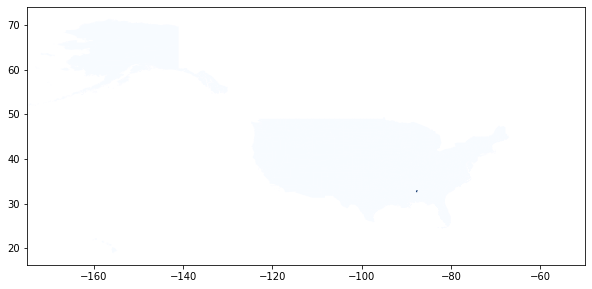

In [26]:
select_county(geo_input, dir_input, com_input)

In [27]:
## folium testing

import folium
from IPython.display import display

county_geo = 'counties.geojson'

m = folium.Map(location=[39.8, -98.5], zoom_start = 2)
folium.TopoJson(open('counties.geojson')).add_to(m)
m

## test
#m.choropleth(
#    geo_data=county_geo,
#    name = 'choropleth',
#    data = fips,
#    columns = ['FIPS_state','FIPS_county'],
#    key_on = 'FIPS',
#    fill_color = 'YlGn',
#    fill_opacity = 0.7,
#    line_opacity = 0.2,
#    legend_name = 'name')

#folium.LayerControl().add_to(m)

TypeError: __init__() missing 1 required positional argument: 'object_path'